In [1]:
import os
import pickle
import glob
import skimage
import skimage.transform
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import sys

sys.path.append('../functions')

import chirp_functions as proc
%matplotlib inline

In [75]:
## STEP 1: PREPROCESS DATA
proc.preprocess_chirp(data_dir = '../../data/kagome-machine/', 
                       frequencies = np.linspace(2.0, 17.0, 650), 
                       targetfile = '../../data/kagome-machine/preprocessed/', 
                       title = 'scppos_', setno = 0)

Found 0 records


FileNotFoundError: [Errno 2] No such file or directory: '../../data/kagome-machine/preprocessed/_2.0_0.pkl'

In [38]:
## 2D fourier transform - NEW!!!!!

from tqdm import tqdm

folder = "../../data/kagome-02.26.2022-center/"

with open(folder + "preprocessed/_6000.0_0.pkl",'rb') as f:
    real_data = pickle.load(f)

print(real_data)

#L_kag = 0.008
#L = L_kag*np.sqrt(3)/2*(np.sqrt(3)+1)
L = 0.01
kxmax = 4*np.pi/(3*np.sqrt(3) * L)
kymax = 2*np.pi/(3*L)
kxs = np.linspace(-2*kxmax, 2*kxmax, 100)
kys = np.linspace(-2*kymax, 2*kymax, 100)

print(L)

G = [[0.0, 0.0], [6*np.pi/(3*np.sqrt(3) * L), 2*np.pi/(3*L)], [6*np.pi/(3*np.sqrt(3) * L), -2*np.pi/(3*L)], [0, 4*np.pi/(3*L)]]
print(G[1][0])

reciprocal_data = np.zeros((len(kxs), len(kys)))
reciprocal_raw = np.zeros((len(kxs), len(kys)), dtype=complex)

[[ 1.00000e+01  2.00000e+00  5.77395e-02  1.22946e+02]
 [ 1.10000e+01  1.00000e+00  4.33352e-02  9.96000e+01]
 [ 1.10000e+01  3.00000e+00  3.90627e-02  7.53240e+01]
 [ 1.20000e+01  0.00000e+00  5.24905e-02  5.81760e+01]
 [ 1.30000e+01  1.00000e+00  4.35793e-02  1.70760e+01]
 [ 1.50000e+01  1.00000e+00  4.89504e-02 -4.98000e+01]
 [ 1.60000e+01  0.00000e+00  5.51760e-02 -7.37640e+01]
 [ 1.70000e+01  1.00000e+00  3.28982e-02 -1.16046e+02]
 [ 1.90000e+01  1.00000e+00  3.64382e-02  1.52310e+02]
 [ 1.00000e+00  1.00000e+00  1.15540e-01  9.81420e+01]
 [ 2.00000e+01  0.00000e+00  4.22976e-02  1.29732e+02]
 [ 2.10000e+01  1.00000e+00  2.66725e-02  9.11400e+01]
 [ 2.30000e+01  1.00000e+00  3.25320e-02 -1.43340e+01]
 [ 2.40000e+01  0.00000e+00  4.92556e-02 -4.29720e+01]
 [ 2.50000e+01  1.00000e+00  3.54006e-02 -6.70260e+01]
 [ 2.60000e+01  2.00000e+00  2.83204e-02 -1.16112e+02]
 [ 2.70000e+01  1.00000e+00  1.92262e-02 -1.39422e+02]
 [ 2.80000e+01  0.00000e+00  2.25221e-02  1.73892e+02]
 [ 2.90000

100%|██████████| 100/100 [00:10<00:00,  9.15it/s]


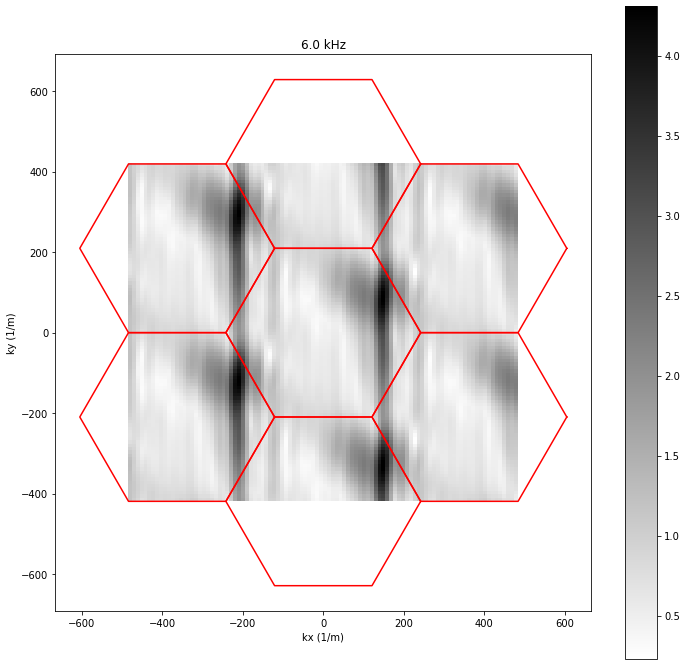

In [39]:
    
'''
Elements of real_data are assumed to look like:
    0: X in mm
    1: Y in mm
    2: Amplitude
    3: Phase in degrees

'''

x_unit = 10*np.sqrt(3)/4/1000
y_unit = 7.5/1000


for yi in tqdm(range(len(kys))):
    for xi in range(len(kxs)):
        for i in range(4):
            k_current=[kxs[xi] + G[i][0], kys[yi] + G[i][1]]
            raw = np.array(
                    [point[2] * np.exp(-1j * (k_current[0] * (point[0]*x_unit) + k_current[1] * (point[1]*y_unit) + (point[3] / 57.2957795131))) 
                        for point in real_data]).sum()
            amplitude = np.abs(raw)
            reciprocal_data[yi][xi] += amplitude
      

        

freq = 6.0
plt.figure(figsize=(12,12))
plt.imshow(reciprocal_data, cmap = 'binary', extent = [-2*kxmax, 2*kxmax, -2*kymax, 2*kymax], aspect = 'equal', origin = 'lower')

xBZ = np.zeros((7,7))
yBZ = np.zeros((7,7))

vec = np.array([[0,0], [np.sqrt(3), 1], [0, 2], [-np.sqrt(3),1], [-np.sqrt(3),-1], [0, -2], [np.sqrt(3),-1]])*kymax
xBZ[0] = [kxmax, 0.5*kxmax, -0.5*kxmax, -kxmax, -0.5*kxmax, 0.5*kxmax, kxmax]
yBZ[0] = [0, kymax, kymax, 0, -kymax, -kymax, 0]

for i in range(7):
    xBZ[i] = xBZ[0] + vec[i][0]
    yBZ[i] = yBZ[0] + vec[i][1]
    plt.plot(xBZ[i], yBZ[i], 'r-')


plt.xlabel("kx (1/m)")
plt.ylabel("ky (1/m)")
plt.title(str(freq)+" kHz")
plt.colorbar()

plt.savefig(folder + "fourier/figures/2D_DFT_{}kHz_NEW.png".format(freq))

100%|██████████| 100/100 [00:02<00:00, 36.04it/s]


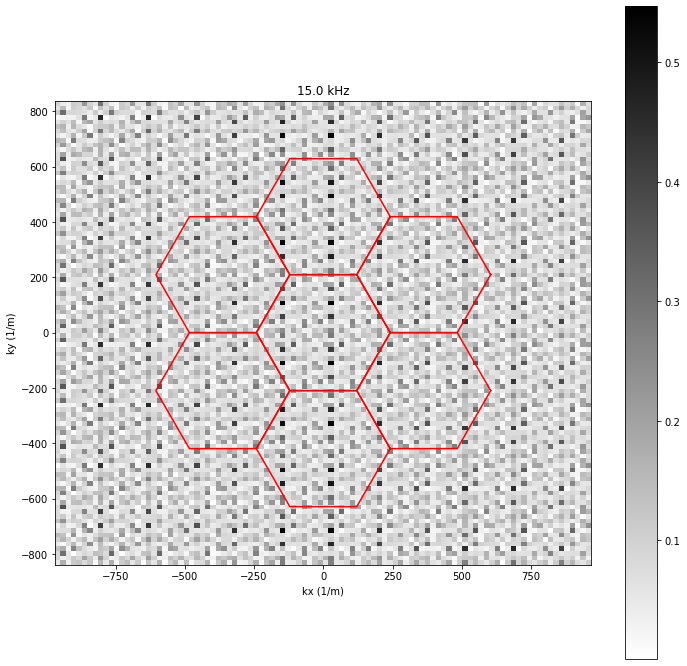

In [15]:
## 2D fourier transform - ORIGINAL!!!

from tqdm import tqdm

folder = "../../data/kagome-02.26.2022-center/"

with open(folder + "preprocessed/_9000.0_0.pkl",'rb') as f:
    real_data = pickle.load(f)



L_kag = 0.008
L = L_kag*np.sqrt(3)/2*(np.sqrt(3)+1)
L = 0.01

kxmax = 4*np.pi/(3*np.sqrt(3) * L)
kymax = 2*np.pi/(3*L)
kxs = np.linspace(-4*kxmax, 4*kxmax, 100)
kys = np.linspace(-4*kymax, 4*kymax, 100)


reciprocal_data = np.zeros((len(kxs), len(kys)))
reciprocal_raw = np.zeros((len(kxs), len(kys)), dtype=complex)

    
'''
Elements of real_data are assumed to look like:
    0: X in mm
    1: Y in mm
    2: Amplitude
    3: Phase in degrees

'''


for yi in tqdm(range(len(kys))):
    for xi in range(len(kxs)):
        raw = np.array(
                [point[2] * np.exp(-1j * (kxs[xi] * (point[0]) + kys[yi] * (point[1]) + (point[3] / 57.2957795131))) 
                    for point in real_data]).sum()
        amplitude = np.abs(raw)
        reciprocal_data[yi][xi] = amplitude
        reciprocal_raw[yi][xi] = raw
      

        

freq = 15.0
plt.figure(figsize=(12,12))
plt.imshow(reciprocal_data, cmap = 'binary', extent = [-4*kxmax, 4*kxmax, -4*kymax, 4*kymax], aspect = 'equal', origin = 'lower')

xBZ = np.zeros((7,7))
yBZ = np.zeros((7,7))

vec = np.array([[0,0], [np.sqrt(3), 1], [0, 2], [-np.sqrt(3),1], [-np.sqrt(3),-1], [0, -2], [np.sqrt(3),-1]])*kymax
xBZ[0] = [kxmax, 0.5*kxmax, -0.5*kxmax, -kxmax, -0.5*kxmax, 0.5*kxmax, kxmax]
yBZ[0] = [0, kymax, kymax, 0, -kymax, -kymax, 0]

for i in range(7):
    xBZ[i] = xBZ[0] + vec[i][0]
    yBZ[i] = yBZ[0] + vec[i][1]
    plt.plot(xBZ[i], yBZ[i], 'r-')


plt.xlabel("kx (1/m)")
plt.ylabel("ky (1/m)")
plt.title(str(freq)+" kHz")
plt.colorbar()

plt.savefig(folder + "fourier/figures/2D_DFT_{}kHz_ORIGINAL.png".format(freq))







[[0
  array([ 1000.,  1040.,  1080.,  1120.,  1160.,  1200.,  1240.,  1280.,
        1320.,  1360.,  1400.,  1440.,  1480.,  1520.,  1560.,  1600.,
        1640.,  1680.,  1720.,  1760.,  1800.,  1840.,  1880.,  1920.,
        1960.,  2000.,  2040.,  2080.,  2120.,  2160.,  2200.,  2240.,
        2280.,  2320.,  2360.,  2400.,  2440.,  2480.,  2520.,  2560.,
        2600.,  2640.,  2680.,  2720.,  2760.,  2800.,  2840.,  2880.,
        2920.,  2960.,  3000.,  3040.,  3080.,  3120.,  3160.,  3200.,
        3240.,  3280.,  3320.,  3360.,  3400.,  3440.,  3480.,  3520.,
        3560.,  3600.,  3640.,  3680.,  3720.,  3760.,  3800.,  3840.,
        3880.,  3920.,  3960.,  4000.,  4040.,  4080.,  4120.,  4160.,
        4200.,  4240.,  4280.,  4320.,  4360.,  4400.,  4440.,  4480.,
        4520.,  4560.,  4600.,  4640.,  4680.,  4720.,  4760.,  4800.,
        4840.,  4880.,  4920.,  4960.,  5000.,  5040.,  5080.,  5120.,
        5160.,  5200.,  5240.,  5280.,  5320.,  5360.,  5400.,  5440.,


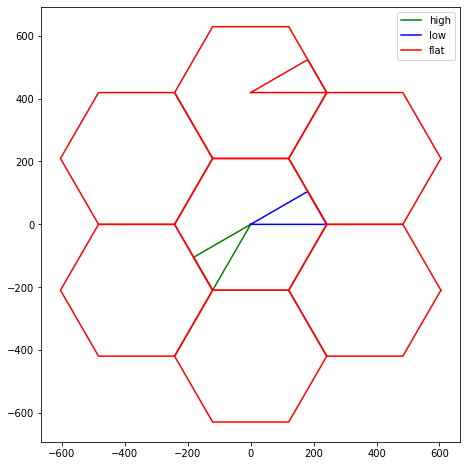

In [7]:
#GK'M'G sweeps

from tqdm import tqdm
import csv



#freqs = np.array([(0, np.array(list(np.linspace(1,16,76))+list(np.linspace(16,17, 51))+list(np.linspace(17,18,6))))], dtype=object)
freq_num = 426
freq_min = 1000.0
freq_max = 18000.0
freqs = np.array([(0, np.linspace(freq_min, freq_max, freq_num))], dtype=object)
print(freqs)

freq_div1 = 9000
freq_div2 = 130000

#L_kag = 0.008
#L = L_kag*np.sqrt(3)/2*(np.sqrt(3)+1)
L = 0.01
kxmax = 4*np.pi/(3*np.sqrt(3) * L)
kymax = 2*np.pi/(3*L)

b_res = 50
b = np.linspace(0, 1.5+np.sqrt(3)/2, b_res) #GKMG sweep parameter

kxb_low = np.zeros(len(b))
kyb_low = np.zeros(len(b))
kxb_high = np.zeros(len(b))
kyb_high = np.zeros(len(b))
kxb_flat = np.zeros(len(b))
kyb_flat = np.zeros(len(b))


for i in range(len(b)):
    if b[i] < 1:   
        
        #kxb_low[i] = b[i] * 2 * np.pi / (np.sqrt(3)*3 * L) 
        #kyb_low[i] = b[i] * 2 * np.pi / (3 * L)
        

        
        kxb_high[i] = -b[i] * 2 * np.pi / (np.sqrt(3)*3 * L) 
        kyb_high[i] = 4 * np.pi / (3 * L) - b[i] * 2 * np.pi / (3 * L)
        kxb_flat[i] = 4 * np.pi / (3 * np.sqrt(3) * L) * b[i]
        kyb_flat[i] = 4 * np.pi / (3 * L) 
        
        kxb_low[i] = kxb_flat[i]
        kyb_low[i] = kyb_flat[i] - 2*kymax
        
        kxb_high[i] = kxb_high[i]
        kyb_high[i] = kyb_high[i] - 2*kymax
        
    elif b[i] < 1.5: 
        #kxb_low[i] = 2 * np.pi / (np.sqrt(3)*3 * L) - 2 * 2 * np.pi / (3 * np.sqrt(3) * L) * (b[i]-1)
        #kyb_low[i] = 2 * np.pi / (3 * L) 
        kxb_high[i] = -2 * np.pi / (np.sqrt(3)*3 * L) + 2 * 2 * np.pi / (3 * np.sqrt(3) * L) * (b[i]-1)
        kyb_high[i] = 2 * np.pi / (3 * L) 
        kxb_flat[i] = 4 * np.pi / (3 * np.sqrt(3) * L) - 2 * np.pi / (3 * np.sqrt(3) * L) * (b[i]-1)
        kyb_flat[i] = 4 * np.pi / (3*L) + 2 * np.pi / (3 * L) * (b[i]-1)
        
        kxb_low[i] = kxb_flat[i] 
        kyb_low[i] = kyb_flat[i] - 2*kymax
        
        kxb_high[i] = kxb_low[i] - 1.5*kxmax
        kyb_high[i] = kyb_low[i] - kymax
    else:
        #kxb_low[i] = 0
        #kyb_low[i] = 2 * np.pi / (3 * L) - 2 * np.pi / (3 * L) *2 / np.sqrt(3) * (b[i]-1.5)
        kxb_high[i] = 0
        kyb_high[i] = 2 * np.pi / (3 * L) + 2 * np.pi / (3 * L) *2 / np.sqrt(3) * (b[i]-1.5)
        kxb_flat[i] = (1- (b[i] - 1.5) * 2 / np.sqrt(3)) * np.pi / (np.sqrt(3) * L)
        kyb_flat[i] = 4 * np.pi / (3*L) + (1- 2 / (np.sqrt(3)) * (b[i]-1.5)) * np.pi / (3 * L)
        
        kxb_low[i] = kxb_flat[i]
        kyb_low[i] = kyb_flat[i] - 2*kymax
        
        kxb_high[i] = -kxb_low[i] 
        kyb_high[i] = -kyb_low[i] 



plt.figure(figsize=(8,8))
#plt.plot(kxb_flat, kyb_flat, 'm-',label='flat')
plt.plot(kxb_high, kyb_high, 'g-',label='high')
plt.plot(kxb_low, kyb_low, 'b-',label='low')
plt.plot(kxb_flat, kyb_flat, 'r-',label='flat')
plt.legend()
ax = plt.gca()
ax.set_aspect('equal')

xBZ = np.zeros((7,7))
yBZ = np.zeros((7,7))

vec = np.array([[0,0], [np.sqrt(3), 1], [0, 2], [-np.sqrt(3),1], [-np.sqrt(3),-1], [0, -2], [np.sqrt(3),-1]])*kymax
xBZ[0] = [kxmax, 0.5*kxmax, -0.5*kxmax, -kxmax, -0.5*kxmax, 0.5*kxmax, kxmax]
yBZ[0] = [0, kymax, kymax, 0, -kymax, -kymax, 0]


for i in range(7):
    xBZ[i] = xBZ[0] + vec[i][0]
    yBZ[i] = yBZ[0] + vec[i][1]
    plt.plot(xBZ[i], yBZ[i], 'r-')


In [20]:
###Original

filename = '../../data/kagome-02.26.2022-center/preprocessed/'

reciprocal_data = np.zeros((freq_num, b_res))
x_unit = 10*np.sqrt(3)/4/1000
y_unit = 7.5/1000

    
for setno, values in freqs:
    for j in tqdm(range(len(values))):
        with open(filename + '_' + str(values[j]) + '_' + str(setno) + '.pkl','rb') as f:
            real_data = pickle.load(f)
            
            if values[j] <= freq_div1:
                
                for i in range(b_res):
                    amplitude = np.abs(np.array(
                            [point[2] * np.exp(1j * (kxb_low[i] * (point[0]*x_unit) + kyb_low[i] * (point[1]*y_unit) + (point[3] / 57.2957795131))) 
                                for point in real_data]).sum())
                    reciprocal_data[j][i] = amplitude
                    
            else:
                
                for i in range(b_res):
                    amplitude = np.abs(np.array(
                            [point[2] * np.exp(1j * (kxb_high[i] * (point[0]*x_unit) + kyb_high[i] * (point[1]*y_unit) + (point[3] / 57.2957795131))) 
                                for point in real_data]).sum())
                    reciprocal_data[j][i] = amplitude
'''          
            else:
                for i in range(b_res):
                    amplitude = np.abs(np.array(
                            [point[2] * np.exp(1j * (kxb_flat[i] * (point[0] / 1000) + kyb_flat[i] * (point[1] / 1000) + (point[3] / 57.2957795131))) 
                                for point in real_data]).sum())
                    reciprocal_data[j][i] = amplitude
'''   

            

100%|██████████| 426/426 [00:06<00:00, 64.79it/s]


'          \n            else:\n                for i in range(b_res):\n                    amplitude = np.abs(np.array(\n                            [point[2] * np.exp(1j * (kxb_flat[i] * (point[0] / 1000) + kyb_flat[i] * (point[1] / 1000) + (point[3] / 57.2957795131))) \n                                for point in real_data]).sum())\n                    reciprocal_data[j][i] = amplitude\n'

/Users/jiatongyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "interpolation" which is no longer supported as of 3.3 and will become an error two minor releases later
/Users/jiatongyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "interpolation" which is no longer supported as of 3.3 and will become an error two minor releases later


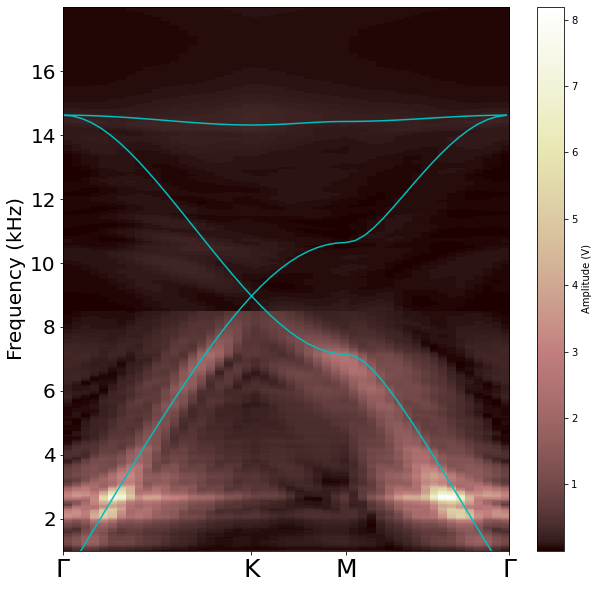

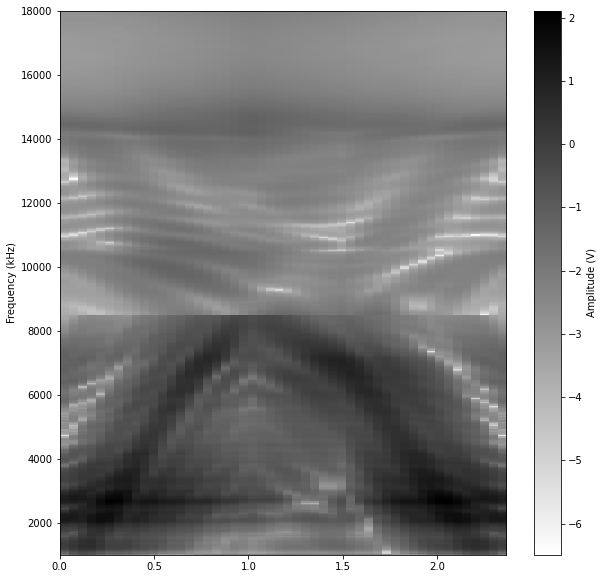

In [23]:
reciprocal_data_plot = np.zeros((freq_num, b_res))


for i in range(len(reciprocal_data)):
    reciprocal_data_plot[i] = reciprocal_data[i]#/np.average(reciprocal_data[i])
    #reciprocal_data_plot[i] = reciprocal_data[i]/reciprocal_data[i][0]
    #reciprocal_data_plot[i] = reciprocal_data[i]/reciprocal_data[i].max()



folder = '../../data/kagome-02.26.2022-center/'

b_sim = []
band1 = []
band2 = []
band3 = []

with open('../../data/simulation/kagome_machine_bands_clean.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    
    for row in reader:
        b_sim.append(float(row[0]))
        band1.append(float(row[1]))
        band2.append(float(row[2]))
        band3.append(float(row[3]))


    
# GKMG sweep
plt.figure(figsize = (10, 10))
color_map = plt.cm.get_cmap('pink')
reversed_magma = color_map.reversed()
plt.imshow(reciprocal_data_plot, cmap = 'pink', extent = [b[0], b[-1], freq_min/1000, freq_max/1000], aspect = 'auto', origin = 'lower', interpolation='none')
plt.plot(b_sim, band1, 'c-')
plt.plot(b_sim, band2, 'c-')
plt.plot(b_sim, band3, 'c-')
plt.colorbar(label = 'Amplitude (V)')
plt.ylabel("Frequency (kHz)", fontsize = 20)
plt.axis([b[0], b[-1], freq_min/1000, freq_max/1000])
plt.yticks(np.linspace(2, 16, 8), fontsize = 20)
plt.xticks([0, 1, 1.5, b[-1]], ['\u0393', 'K', 'M', '\u0393'], fontsize=25)
plt.savefig(folder + "fourier/figures/GK'M'G_sweep2_ORIGINAL", interpolation='none')


plt.figure(figsize = (10, 10))
plt.imshow(np.log(reciprocal_data_plot), cmap = 'binary', extent = [b[0], b[-1], freq_min, freq_max], aspect = 'auto', origin = 'lower', interpolation='none')
plt.colorbar(label = 'Amplitude (V)')
plt.plot(b_sim, band1, 'y-')
plt.plot(b_sim, band2, 'y-')
plt.plot(b_sim, band3, 'y-')
plt.ylabel("Frequency (kHz)")
plt.axis([b[0], b[-1], freq_min, freq_max])
plt.savefig(folder + "fourier/figures/GK'M'G_sweep2_binary_ORIGINAL", interpolation='none')

In [9]:
###New

filename = '../../data/kagome-02.26.2022-center/preprocessed/'

reciprocal_data = np.zeros((freq_num, b_res))
x_unit = 10*np.sqrt(3)/4/1000
y_unit = 7.5/1000

G = [[0.0, 0.0], [6*np.pi/(3*np.sqrt(3) * L), 2*np.pi/(3*L)], [6*np.pi/(3*np.sqrt(3) * L), -2*np.pi/(3*L)], [0, 4*np.pi/(3*L)]]
    
for setno, values in freqs:
    for j in tqdm(range(len(values))):
        with open(filename + '_' + str(values[j]) + '_' + str(setno) + '.pkl','rb') as f:
            real_data = pickle.load(f) 
            
            if values[j] <= freq_div1:
                
                for i in range(b_res):
                    for k_no in range(4):
                        k_current = [kxb_low[i] + G[k_no][0], kyb_low[i] + G[k_no][1]]
                        amplitude = np.abs(np.array(
                                [point[2] * np.exp(1j * (k_current[0] * (point[0]*x_unit) + k_current[1] * (point[1]*y_unit) + (point[3] / 57.2957795131))) 
                                    for point in real_data]).sum())
                        reciprocal_data[j][i] += amplitude
                        
            else:
                for i in range(b_res):
                    for k_no in range(4):
                        k_current = [kxb_high[i] + G[k_no][0], kyb_high[i] + G[k_no][1]]
                        amplitude = np.abs(np.array(
                                [point[2] * np.exp(1j * (k_current[0] * (point[0]*x_unit) + k_current[1] * (point[1]*y_unit) + (point[3] / 57.2957795131))) 
                                    for point in real_data]).sum())
                        reciprocal_data[j][i] += amplitude
 

            

reciprocal_data_plot = np.zeros((freq_num, b_res))


for i in range(len(reciprocal_data)):
    reciprocal_data_plot[i] = reciprocal_data[i]

100%|██████████| 426/426 [00:24<00:00, 17.74it/s]


/Users/jiatongyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "interpolation" which is no longer supported as of 3.3 and will become an error two minor releases later
/Users/jiatongyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "interpolation" which is no longer supported as of 3.3 and will become an error two minor releases later


'\nplt.figure(figsize = (10, 10))\n#plt.imshow(reciprocal_data_plot[np.linspace(1,76,76).astype(int)], cmap = \'binary\', extent = [b[0], b[-1], 1, 16], aspect = \'auto\', origin = \'lower\', interpolation=\'none\')\n#plt.imshow(reciprocal_data_plot[np.linspace(77,77+51,51).astype(int)], cmap = \'binary\', extent = [b[0], b[-1], 16, 17], aspect = \'auto\', origin = \'lower\', interpolation=\'none\')\n#plt.imshow(reciprocal_data_plot[np.linspace(77+51,77+51+6,6).astype(int)], cmap = \'binary\', extent = [b[0], b[-1], 17, 18], aspect = \'auto\', origin = \'lower\', interpolation=\'none\')\nplt.imshow(reciprocal_data_plot, cmap = \'binary\', extent = [b[0], b[-1], 1, 18], aspect = \'auto\', origin = \'lower\', interpolation=\'none\')\nplt.colorbar(label = \'Amplitude (V)\')\nplt.plot(b_sim, band1, \'y-\')\nplt.plot(b_sim, band2, \'y-\')\nplt.plot(b_sim, band3, \'y-\')\nplt.ylabel("Frequency (kHz)")\nplt.axis([b[0], b[-1], 1, 18])\nplt.savefig(folder + "fourier/figures/GK\'M\'G_sweep2_bina

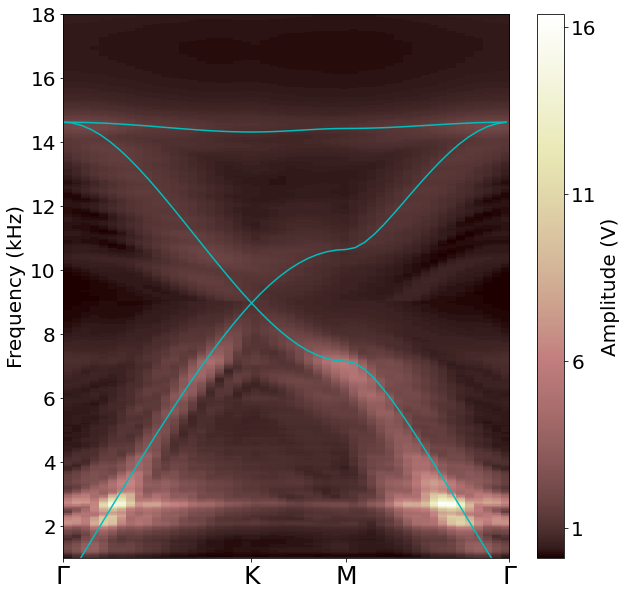

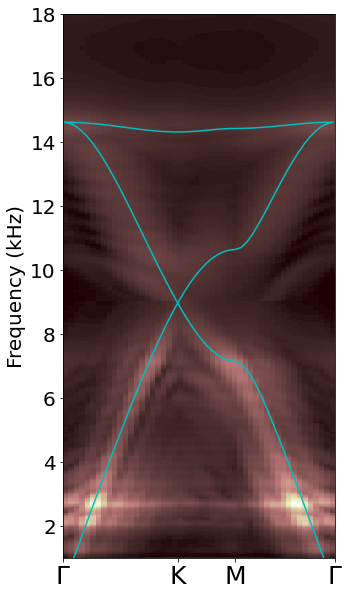

In [40]:
folder = '../../data/kagome-02.26.2022-center/'

b_sim = []
band1 = []
band2 = []
band3 = []


with open('../../data/simulation/kagome_machine_bands_clean.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    
    for row in reader:
        b_sim.append(float(row[0]))
        band1.append(float(row[1]))
        band2.append(float(row[2]))
        band3.append(float(row[3]))


    
# GKMG sweep
plt.figure(figsize = (10, 10))
color_map = plt.cm.get_cmap('inferno')
reversed_magma = color_map.reversed()
#plt.imshow(reciprocal_data_plot[np.linspace(1,76,76).astype(int)], cmap = 'pink', extent = [b[0], b[-1], 1, 16], aspect = 'auto', origin = 'lower', interpolation='none')
#plt.imshow(reciprocal_data_plot[np.linspace(77,77+50,51).astype(int)], cmap = 'pink', extent = [b[0], b[-1], 16, 17], aspect = 'auto', origin = 'lower', interpolation='none')
#plt.imshow(reciprocal_data_plot[np.linspace(77+51,77+51+5,6).astype(int)], cmap = 'pink', extent = [b[0], b[-1], 17, 18], aspect = 'auto', origin = 'lower', interpolation='none')
#plt.imshow(reciprocal_data_plot[np.linspace(1,550,550).astype(int)], cmap = 'pink', extent = [b[0], b[-1], freq_min/1000, freq_max/1000], aspect = 'auto', origin = 'lower', interpolation='none')
plt.imshow(reciprocal_data_plot, cmap = 'pink', extent = [b[0], b[-1], freq_min/1000, freq_max/1000], aspect = 'auto', origin = 'lower', interpolation='none')
plt.plot(b_sim, band1, 'c-')
plt.plot(b_sim, band2, 'c-')
plt.plot(b_sim, band3, 'c-')
#plt.colorbar(label = 'Amplitude (V)')
cb = plt.colorbar()
cb.set_label(label='Amplitude (V)',size=20)
cb.set_ticks(np.linspace(1, 16, 4))
cb.ax.tick_params(labelsize=20)
plt.ylabel("Frequency (kHz)", fontsize = 20)
plt.axis([b[0], b[-1], 1, 18])
plt.yticks(np.linspace(2, 18, 9), fontsize = 20)
plt.xticks([0, 1, 1.5, b[-1]], ['\u0393', 'K', 'M', '\u0393'], fontsize=25)
plt.savefig(folder + "fourier/figures/GK'M'G_sweep2_NEW", interpolation='none')


plt.figure(figsize = (6, 10))
color_map = plt.cm.get_cmap('inferno')
reversed_magma = color_map.reversed()
#plt.imshow(reciprocal_data_plot[np.linspace(1,76,76).astype(int)], cmap = 'pink', extent = [b[0], b[-1], 1, 16], aspect = 'auto', origin = 'lower', interpolation='none')
#plt.imshow(reciprocal_data_plot[np.linspace(77,77+50,51).astype(int)], cmap = 'pink', extent = [b[0], b[-1], 16, 17], aspect = 'auto', origin = 'lower', interpolation='none')
#plt.imshow(reciprocal_data_plot[np.linspace(77+51,77+51+5,6).astype(int)], cmap = 'pink', extent = [b[0], b[-1], 17, 18], aspect = 'auto', origin = 'lower', interpolation='none')
#plt.imshow(reciprocal_data_plot[np.linspace(1,550,550).astype(int)], cmap = 'pink', extent = [b[0], b[-1], freq_min/1000, freq_max/1000], aspect = 'auto', origin = 'lower', interpolation='none')
plt.imshow(reciprocal_data_plot, cmap = 'pink', extent = [b[0], b[-1], freq_min/1000, freq_max/1000], aspect = 'auto', origin = 'lower', interpolation='none')
plt.plot(b_sim, band1, 'c-')
plt.plot(b_sim, band2, 'c-')
plt.plot(b_sim, band3, 'c-')
#plt.colorbar(label = 'Amplitude (V)')
#cb = plt.colorbar()
#cb.set_label(label='Amplitude (V)',size=20)
#cb.set_ticks(np.linspace(1, 16, 4))
#cb.ax.tick_params(labelsize=20)
plt.ylabel("Frequency (kHz)", fontsize = 20)
plt.axis([b[0], b[-1], 1, 18])
plt.yticks(np.linspace(2, 18, 9), fontsize = 20)
plt.xticks([0, 1, 1.5, b[-1]], ['\u0393', 'K', 'M', '\u0393'], fontsize=25)
ax = plt.gca()
ax.set_box_aspect(2)
plt.savefig(folder + "fourier/figures/GK'M'G_sweep2_NEW_thin", interpolation='none')


'''
plt.figure(figsize = (10, 10))
#plt.imshow(reciprocal_data_plot[np.linspace(1,76,76).astype(int)], cmap = 'binary', extent = [b[0], b[-1], 1, 16], aspect = 'auto', origin = 'lower', interpolation='none')
#plt.imshow(reciprocal_data_plot[np.linspace(77,77+51,51).astype(int)], cmap = 'binary', extent = [b[0], b[-1], 16, 17], aspect = 'auto', origin = 'lower', interpolation='none')
#plt.imshow(reciprocal_data_plot[np.linspace(77+51,77+51+6,6).astype(int)], cmap = 'binary', extent = [b[0], b[-1], 17, 18], aspect = 'auto', origin = 'lower', interpolation='none')
plt.imshow(reciprocal_data_plot, cmap = 'binary', extent = [b[0], b[-1], 1, 18], aspect = 'auto', origin = 'lower', interpolation='none')
plt.colorbar(label = 'Amplitude (V)')
plt.plot(b_sim, band1, 'y-')
plt.plot(b_sim, band2, 'y-')
plt.plot(b_sim, band3, 'y-')
plt.ylabel("Frequency (kHz)")
plt.axis([b[0], b[-1], 1, 18])
plt.savefig(folder + "fourier/figures/GK'M'G_sweep2_binary_NEW")
'''

In [41]:
# Find peaks in the band structure and scatter them

from scipy.signal import find_peaks

peaks = []
peak_count = 2

freqs = np.linspace(freq_min, freq_max, freq_num)

scatterX = []
scatterY = []

folder = '../../data/sim_kagome25_central_triangle/'

for i in range(550): #214-428: 12-18 kHZ
    
    def peakValue(index):
        return reciprocal_data[i][index]

    peak_indices, _ = find_peaks(reciprocal_data[i])
    peak_indices = list(peak_indices)
    peak_indices.sort(key = peakValue, reverse = True)
    
    for j in range(peak_count):
        scatterX.append(b[peak_indices[j]])
        scatterY.append(freqs[i])

plt.figure(figsize=(8,10))
plt.plot(b_sim, np.array(band1), 'r-')
plt.plot(b_sim, np.array(band2), 'r-')
plt.plot(b_sim, np.array(band3), 'r-')
plt.scatter(scatterX, np.array(scatterY), 10)
plt.ylabel("Frequency (kHz)", fontsize = 20)
plt.axis([b[0], b[-1], freq_min/1000, freq_max/1000])
plt.yticks(np.linspace(2, 16, 8), fontsize = 20)
plt.yticks(np.linspace(2, 16, 8), fontsize = 20)
plt.xticks([0, 1, 1.5, b[-1]], ['\u0393', 'K', 'M', '\u0393'], fontsize=25)
plt.grid()
plt.savefig(folder + "fourier/figures/GKMG_sweep2_peaks_2_new" + str(peak_count))

# GKMG sweep




        
print(folder)

IndexError: list index out of range

transducer 1 phase: -11.563638137575591
transducer 2 phase: -174.54750012821916
5205.955345749948


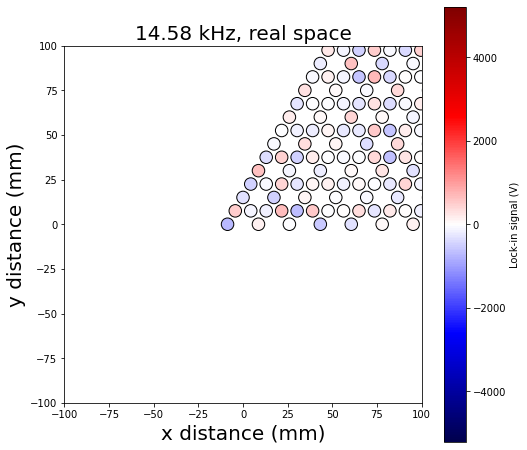

In [4]:
# Animating chirp scans

from matplotlib import patches as ptc
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import matplotlib.colors as colors


kagome_lattice = [((-0.8660,  0.0000), 0.35),
                ((-0.4330,  0.750), 0.35),
                (( 0.4330,  0.750), 0.35),
                (( 0.8660,  0.0000), 0.35),
                (( 0.4330, -0.750), 0.35),
                ((-0.4330, -0.750), 0.35)]


folder = "../../data/sim_kagome25_central_triangle/"

with open(folder + "preprocessed/_14.576923076923078_0.pkl",'rb') as f:
    real_data = pickle.load(f)    
    

lattice_offset = kagome_lattice[4][0]
unit_cell = 10.0
radius = kagome_lattice[0][1]*unit_cell

amp = real_data[:, 2]
amp = amp.tolist()
max_amp = max(amp)
#max_amp = 1.0

freq = 14.58
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_aspect("equal")
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_xlabel("x distance (mm)", fontsize=20)
ax.set_ylabel("y distance (mm)", fontsize=20)
ax.set_title(str(freq) + " kHz, real space", fontsize=20)
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=-max_amp, vmax=max_amp), cmap = "seismic"), ax=ax, label="Lock-in signal (V)")

cavities = []
ampdata = []
phasedata = []
t = 0
dt = 0.1

for point in real_data:
    x_center = point[0]*1000
    y_center = point[1]*1000
    
    if (y_center == 12 * 7.5) and (x_center > 75) and (x_center < 90):
        print("transducer 1 phase: " + str(point[3]))
    
    if (y_center == 12 * 7.5) and (x_center > 90) and (x_center < 105):
        print("transducer 2 phase: " + str(point[3]))
    
    #ampdata.append(np.sqrt(point[2])*np.sqrt(max_amp))
    ampdata.append(point[2])
    phasedata.append(point[3])
    

    
    pressure = ampdata[-1]*np.sin(np.deg2rad(phasedata[-1]))
    #pressure = np.sin(np.deg2rad(phasedata[-1]))

    circle = ptc.Ellipse((x_center, y_center), 
                     width = radius*2, 
                     height = radius*2, 
                     edgecolor='black', facecolor = plt.cm.seismic((pressure+max_amp)/(2.0*max_amp)),
                     fill = True, alpha = 1)
    cavities.append(circle)
    ax.add_patch(cavities[-1])
    
def init():
    """initialize animation"""
    global cavities, t
    
    t = 0
    
    for i in range(len(cavities)):
        pressure = ampdata[i]*np.sin(np.deg2rad(phasedata[i])+t)
        #pressure = np.sin(np.deg2rad(phasedata[i]) + t)
        
        cavities[i].set_facecolor(plt.cm.seismic((pressure+max_amp)/(2.0*max_amp)))
                             
    return cavities
    
def animate(j):
    global t, dt, cavities, ampdata, phasedata
    t += dt
                            
    for i in range(len(cavities)):
        pressure = ampdata[i]*np.sin(np.deg2rad(phasedata[i]+j))
        #pressure = np.sin(np.deg2rad(phasedata[i]) + j)
        cavities[i].set_facecolor(plt.cm.seismic((pressure+max_amp)/(2.0*max_amp)))
                             
    return cavities

ani = animation.FuncAnimation(fig, animate, frames = 360, interval = 20, blit = True, init_func = init)
print(max_amp)

In [19]:
ani.save(folder + 'animations/' + str(freq) + 'kHz.gif', writer = 'imagemagick', fps = 60)

In [17]:
from IPython.display import HTML, Image

Image(url = folder + 'animations/' + str(freq) + 'kHz_sqrt.gif')

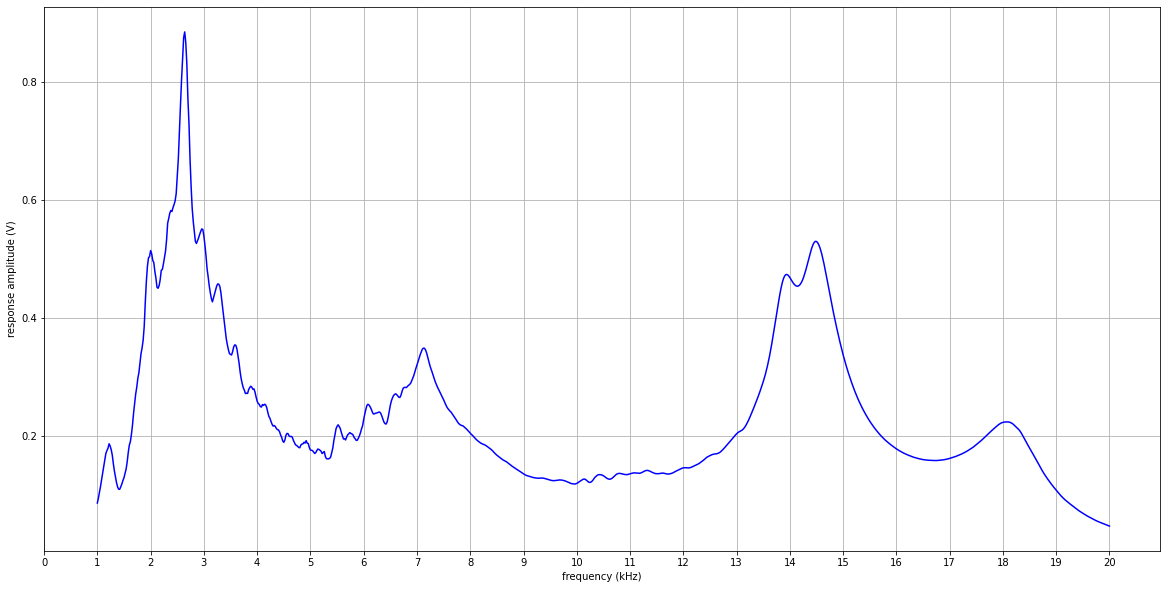

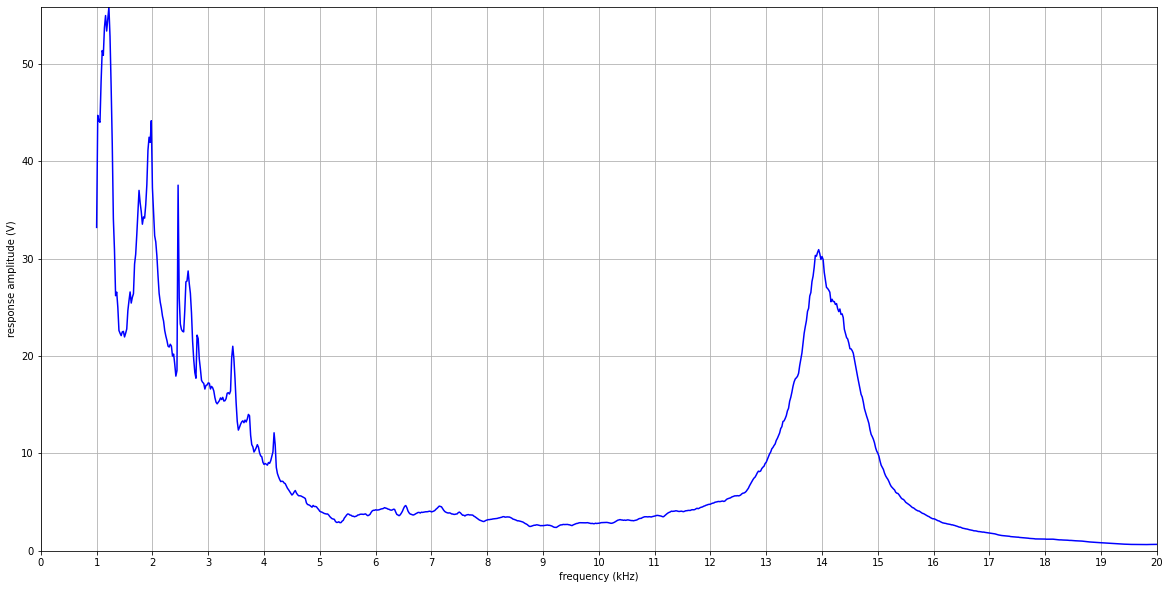

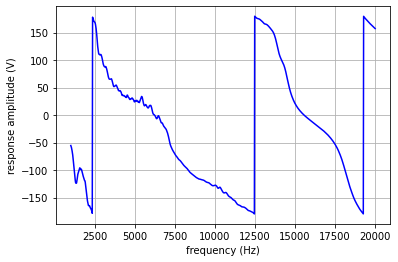

In [127]:
import matplotlib.pyplot as plt
import pickle
import numpy as np


with open('../../data/kagome-01.15.2022-1transducer/data/scppos_1_-1.pkl', 'rb') as f:
    data = pickle.load(f)

with open('../../data/kagome-01.15.2022-1transducer/data/noMetamaterial3.pkl', 'rb') as f:
    ref = pickle.load(f)


freq = data[:,0]
amplitude = data[:,1]
phase = data[:,2]


normFactor = ref[:,1]



plt.figure(figsize=(20,10))
plt.plot(freq/1000, amplitude, 'b-')
#plt.axis([0, 20, 0, 0.2])
plt.xlabel("frequency (kHz)")
plt.ylabel("response amplitude (V)")
plt.xticks(np.linspace(0, 20, 21))
plt.grid()
plt.savefig("../../data/kagome-01.15.2022-1transducer/figures/1_-1_amp.png")

plt.figure(figsize=(20,10))
plt.plot(freq/1000, amplitude/normFactor, 'b-')
plt.axis([4, 20, 0, max(amplitude/normFactor)])
plt.xlabel("frequency (kHz)")
plt.ylabel("response amplitude (V)")
plt.xticks(np.linspace(0, 20, 21))
plt.grid()


plt.figure()
plt.plot(freq, phase, 'b-')
#plt.axis([0, 20000, 0, 0.25])
plt.xlabel("frequency (Hz)")
plt.ylabel("response amplitude (V)")
plt.grid()
plt.savefig("../../data/kagome-01.15.2022-1transducer/figures/1_-1_phase.png")